In [2]:
import numpy as np
import kagglehub
import os
from collections import defaultdict
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [3]:
if not os.path.exists("/content/data"):
  !kaggle datasets download -d hojjatk/mnist-dataset -p /content
  !unzip /content/mnist-dataset.zip -d /content/data
  !rm /content/mnist-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 91% 20.0M/22.0M [00:00<00:00, 69.9MB/s]
100% 22.0M/22.0M [00:00<00:00, 70.0MB/s]
Archive:  /content/mnist-dataset.zip
  inflating: /content/data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: /content/data/t10k-images.idx3-ubyte  
  inflating: /content/data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: /content/data/t10k-labels.idx1-ubyte  
  inflating: /content/data/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: /content/data/train-images.idx3-ubyte  
  inflating: /content/data/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: /content/data/train-labels.idx1-ubyte  


In [4]:
import numpy as np
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Assuming the file is in the /content/mnist-dataset directory
images = read_idx('/content/data/train-images-idx3-ubyte/train-images-idx3-ubyte')
labels = read_idx('/content/data/train-labels-idx1-ubyte/train-labels-idx1-ubyte')

print(images.shape)  # Print the shape of the image data
print(labels.shape)  # Print the shape of the label datan

(60000, 28, 28)
(60000,)


In [5]:
num_pixels = 28 * 28  # Total number of pixels in MNIST images
num_images = images.shape[0]
pixelThreshold = 100

# Find all pixel indices where value > pixelThreshold
image_idx, row_idx, col_idx = np.where(images > pixelThreshold)

# Convert (row, col) to a 1D pixel index
pixel_nums = row_idx * 28 + col_idx

# Create a sparse binary activation matrix
# shape = 28*28 pixels for each image
# initialize with 1 for where pixels are above threshold
# np.ones(len(image_idx)) - make an array of 1 for each pixel above threshold
# place 1s from ^ in these row,col indices (image_idx, pixel_nums)
activation_matrix = csr_matrix(
    (np.ones(len(image_idx), dtype=np.uint16), (image_idx, pixel_nums)),
    shape=(num_images, num_pixels)
)

assert np.all((activation_matrix.data == 0) | (activation_matrix.data == 1)), "Matrix contains invalid values!"

# matrix of numPixels by numPixels - shows how often pixel i was activated with pixel j
co_occurrence_matrix = activation_matrix.T @ activation_matrix
co_occurrence_matrix = co_occurrence_matrix.astype(np.uint16)

# Convert to CSR format for efficient lookups
co_occurrence_matrix = co_occurrence_matrix.tocsr()

Hypothesis: I would expect that in a co-occurrence matrix for ALL images - the highest co-occurring pixels would be those around the center? since most numbers seem to go towards the center?

Result: Yes center is common but the top center and bottom center seem to have the highest concentration of pixels commonly occuring with other pixels

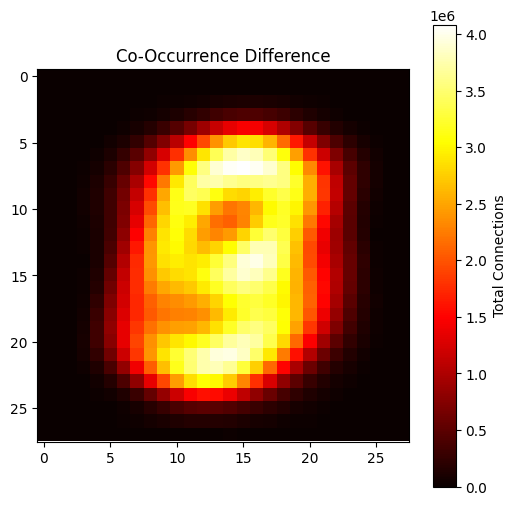

In [36]:
def plot_heatmap(matrix, title="Co-Occurrence Difference"):
    # Calculate the total number of connections for each pixel
    pixel_connections = matrix.sum(axis=1)
    # Convert 1D pixel scores to a 28x28 image
    connection_heatmap = pixel_connections.reshape(28, 28)

    # Plot the heatmap
    plt.figure(figsize=(6,6))
    plt.imshow(connection_heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar(label="Total Connections")
    plt.title(title)
    plt.show()

plot_heatmap(co_occurrence_matrix)

In [33]:
# Get unique labels
unique_labels = np.unique(labels)

# Dictionary to store co-occurrence matrices for each label
label_co_occurrence_matrices = {}

# Compute co-occurrence matrix for each label separately
for label in unique_labels:
    # Select images that belong to this label
    label_indices = np.where(labels == label)[0]

    # Subset activation matrix for these images only
    label_activation_matrix = activation_matrix[label_indices]

    # Compute co-occurrence matrix for this label
    label_co_occurrence_matrix = label_activation_matrix.T @ label_activation_matrix
    label_co_occurrence_matrix = label_co_occurrence_matrix.astype(np.uint16).tocsr().toarray()

    # Store in dictionary
    label_co_occurrence_matrices[label] = label_co_occurrence_matrix

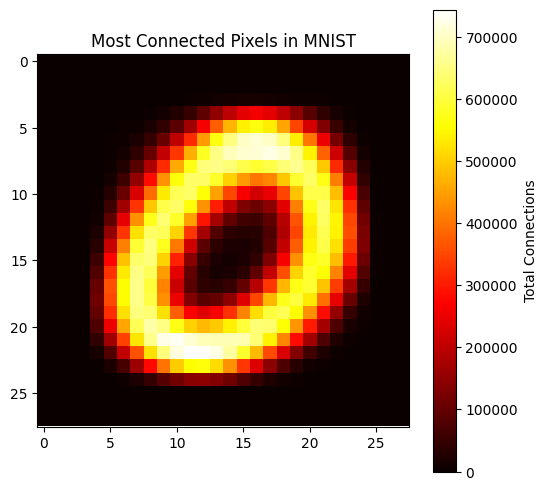

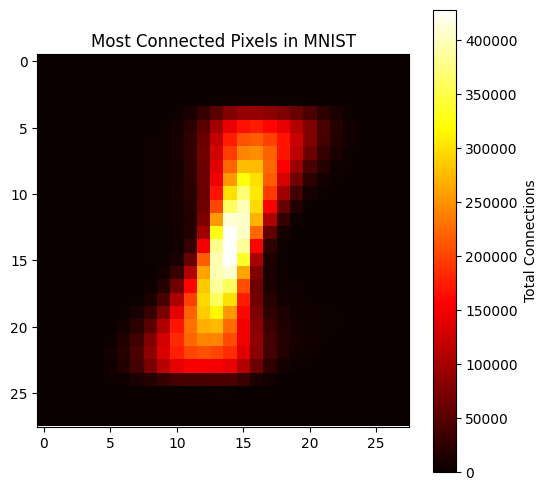

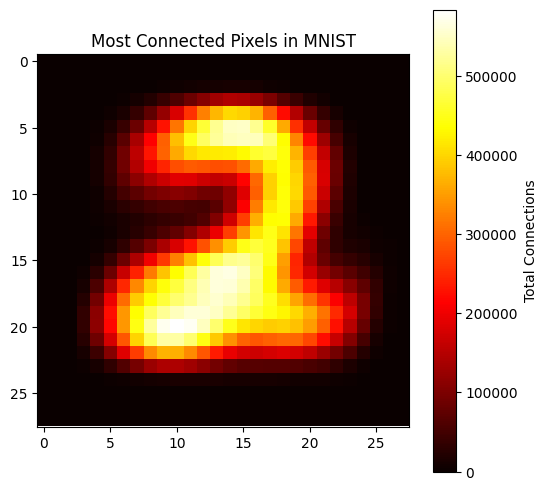

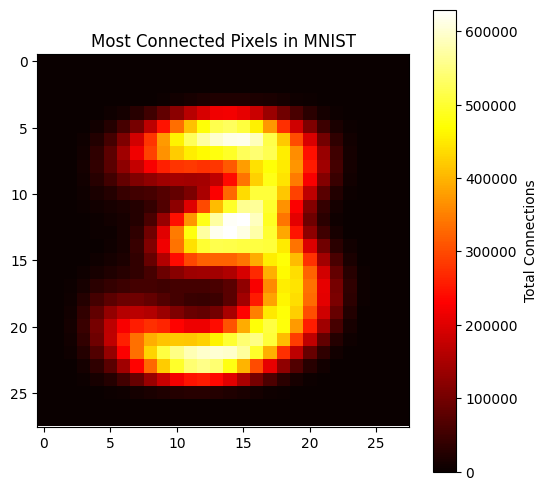

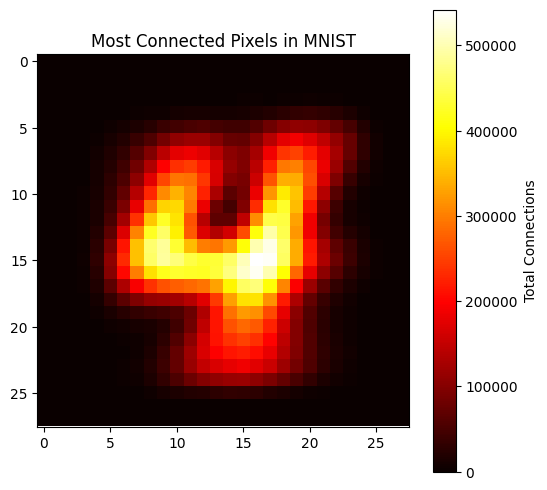

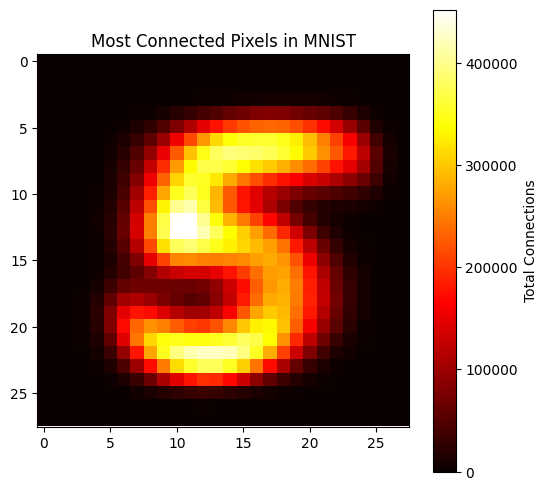

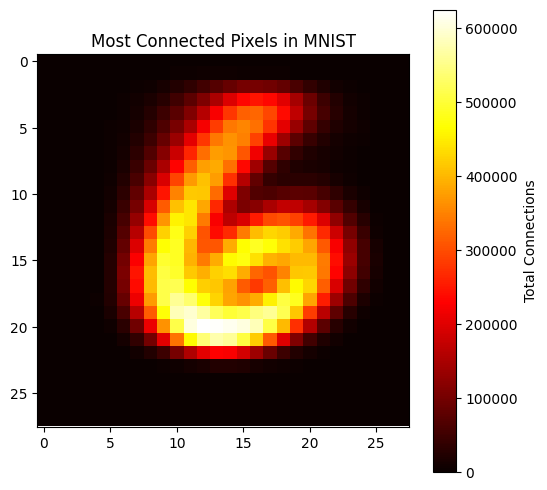

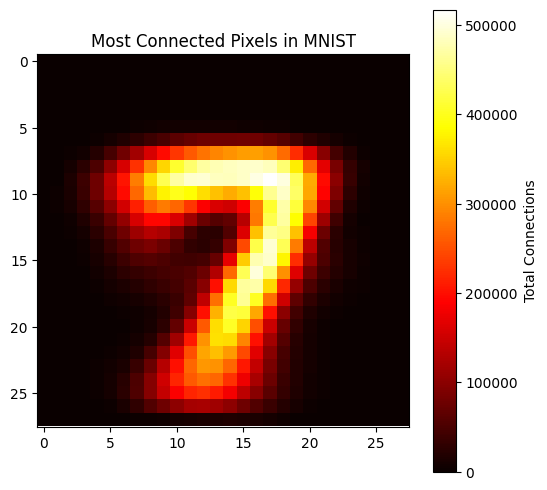

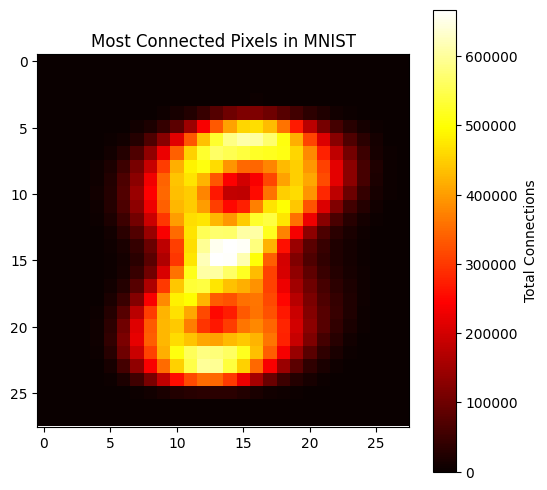

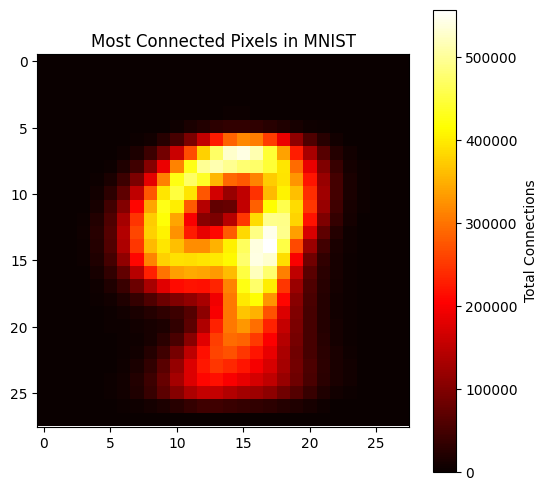

In [34]:
for k,v in label_co_occurrence_matrices.items():
    plot_heatmap(v)

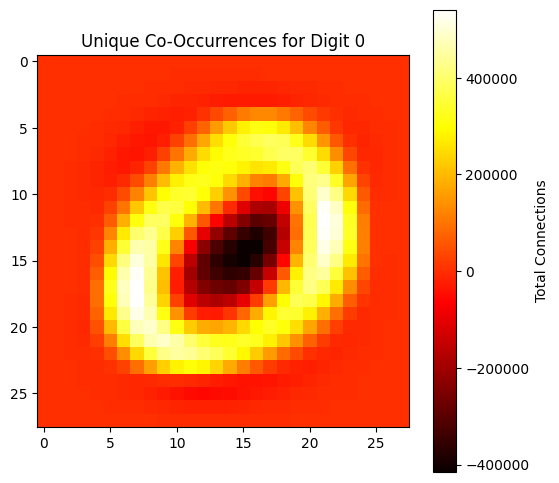

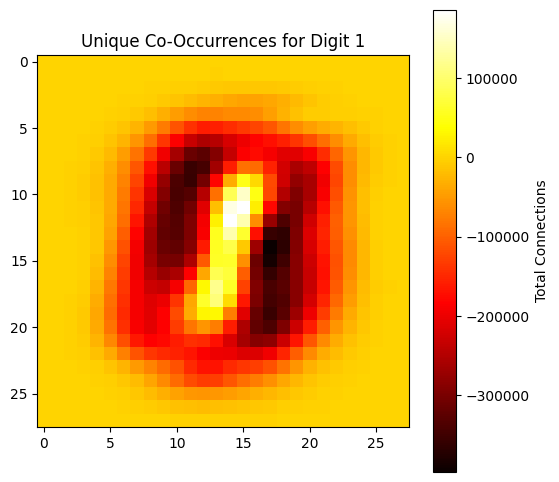

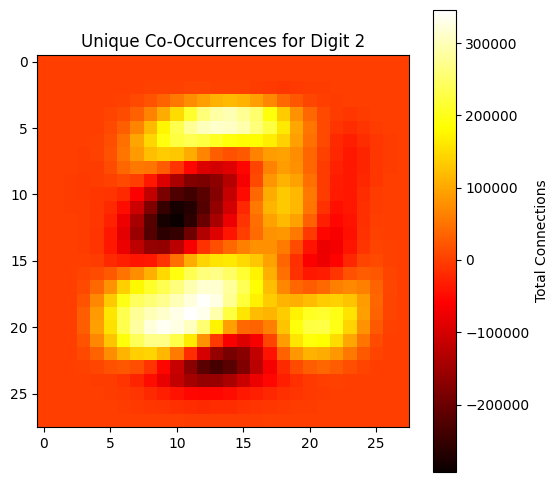

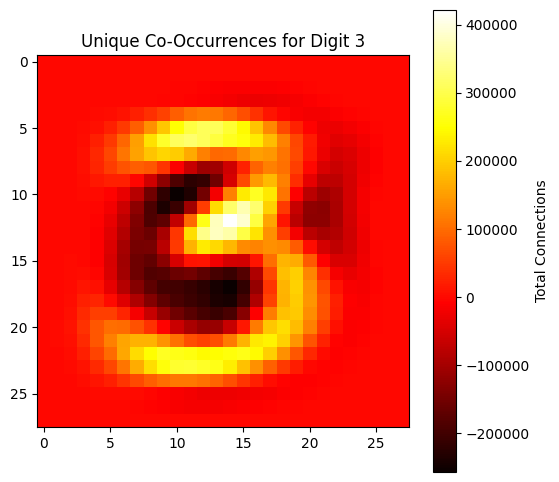

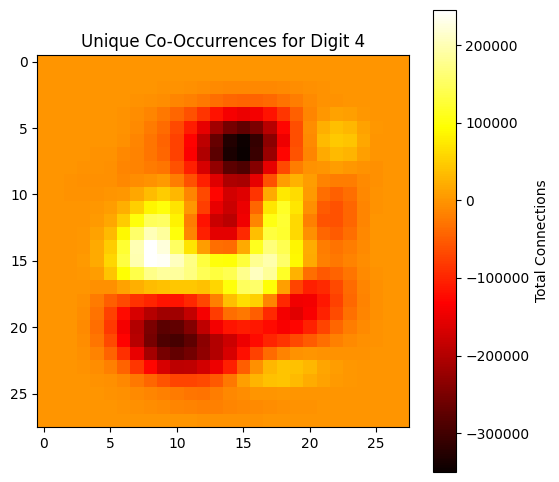

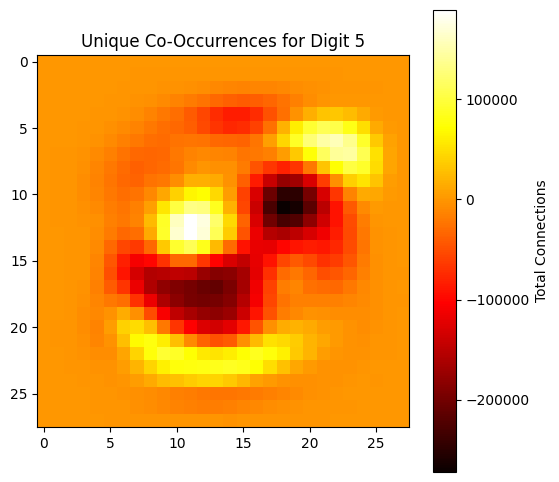

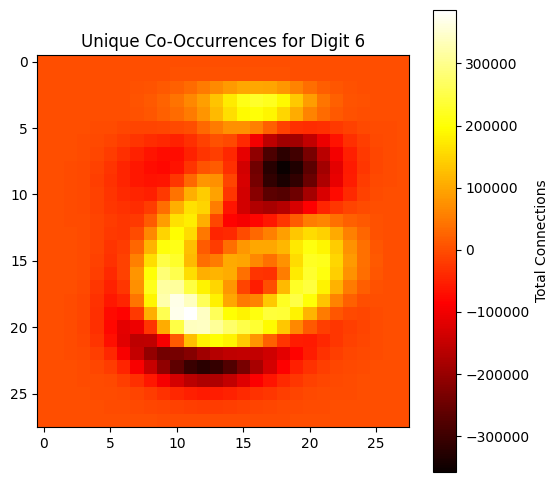

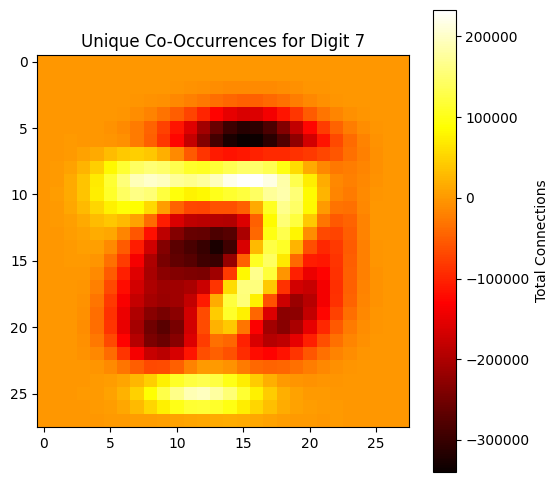

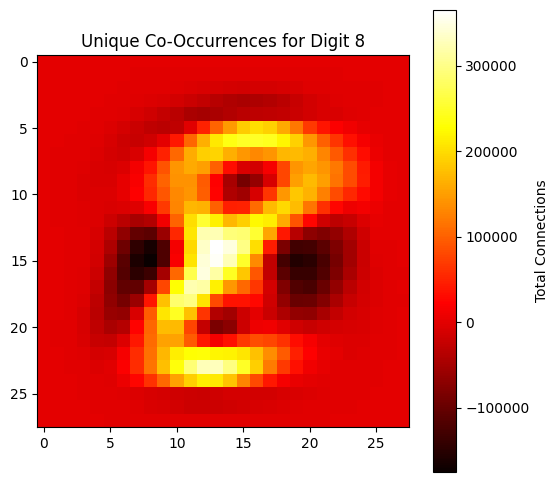

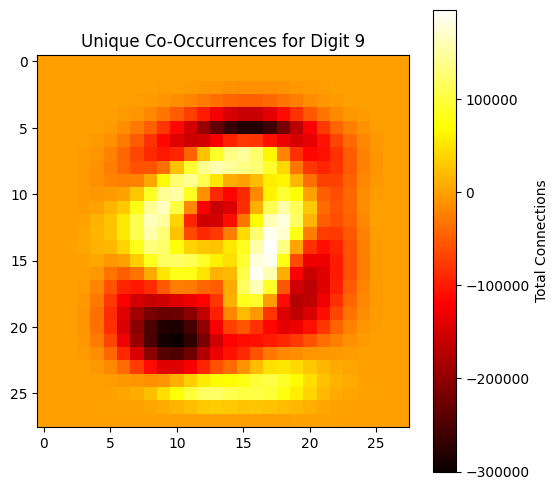

In [37]:
# Compute the "uniqueness" of each co-occurrence matrix
unique_co_occurrences = {}

for k1, v1 in label_co_occurrence_matrices.items():
    # Compute the average co-occurrence matrix of all other digits
    avg_other_matrices = np.mean([v2 for k2, v2 in label_co_occurrence_matrices.items() if k2 != k1], axis=0)

    # Compute the difference between this digit and the average of all others
    unique_matrix = v1 - avg_other_matrices

    # Store result
    unique_co_occurrences[k1] = csr_matrix(unique_matrix)  # Keep as sparse matrix to save memory

    # Plot heatmap of unique co-occurrences
    plot_heatmap(unique_matrix, title=f"Unique Co-Occurrences for Digit {k1}")